# Simulated binary tree data

Here, we introduce a basic Ocelli pipeline for analyzing multi-view datasets.

Remark: We recommend using 3D interactive plots when visualizing data. Unfortunately, these plots are not compatible with the ReadTheDocs online documentation, so here we show only static 2D plots.

In [1]:
import ocelli as oci

Apart from importing Ocelli, we change matplotlib setting to display larger plots.

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200

Ocelli is integrated with the annotated data structure [AnnData](https://anndata.readthedocs.io/en/latest/), which can be stored as a .h5ad file. Such files can be loaded using [scanpy](https://scanpy.readthedocs.io/en/stable/).

In [3]:
import scanpy as scp

x = scp.read_h5ad('toy_model.h5ad')
x

AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    obsm: 'view0', 'view1', 'view2'

Toy model consists of three 3-dimensional views and 6000 cells. Cells are split equally into 6 cell types named after letters A-F.

If we don't have a preprepared AnnData object, we need to create one. 
In this toy model, we have three views, without an expression matrix. 
Below we initiate the new AnnData object with views (numpy.ndarray objects) in x.obsm. 
Additionally, we save metadata in adata.obs: celltype labels, and cell development pseudotime.

In [4]:
from anndata import AnnData
import numpy as np

x = AnnData(np.zeros((6000, 1)))
x.obsm['view0'] = np.genfromtxt('view0.csv', delimiter=',')
x.obsm['view1'] = np.genfromtxt('view1.csv', delimiter=',')
x.obsm['view2'] = np.genfromtxt('view2.csv', delimiter=',')

d = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}
x.obs['celltype'] = [d[i // 1000] for i in range(6000)]

x.obs['pseudotime'] = np.concatenate([[i for i in range(k*1000, (k+1)*1000)] for k in [0, 0, 1, 1, 2, 2]])
x

AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    obsm: 'view0', 'view1', 'view2'

Now, we visualize 3D views by projecting them onto a plane.

The first view:

(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot:>)

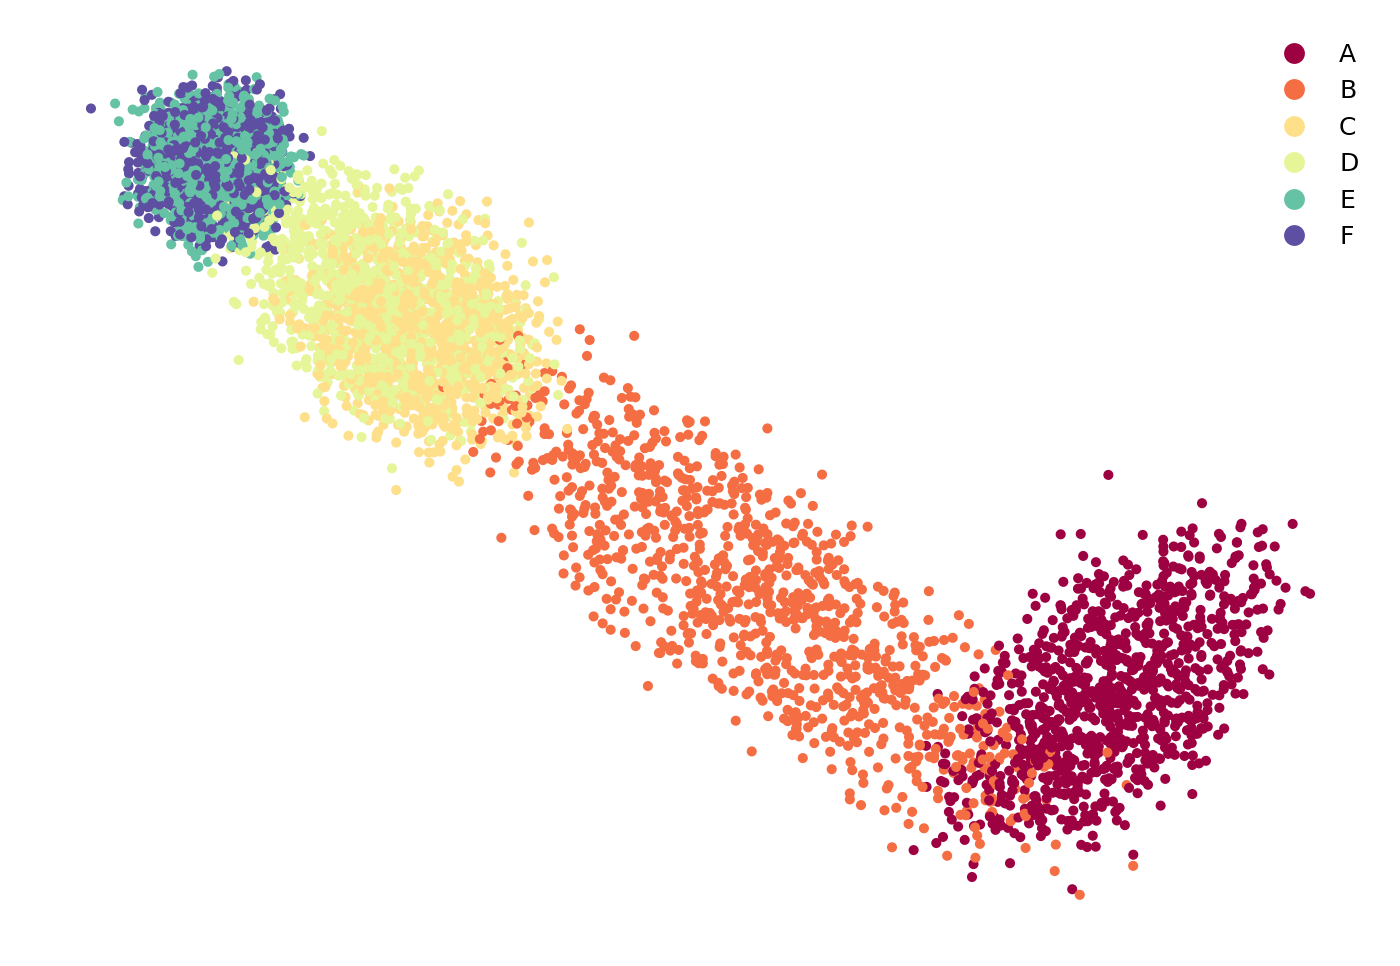

In [5]:
oci.tl.project_2d(x, x_key='view0', projection_key='view0_proj', alpha=30, beta=0)
oci.pl.scatter(x, x_key='view0_proj', color_key='celltype', static=True, marker_size=2)

The second view:

(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot:>)

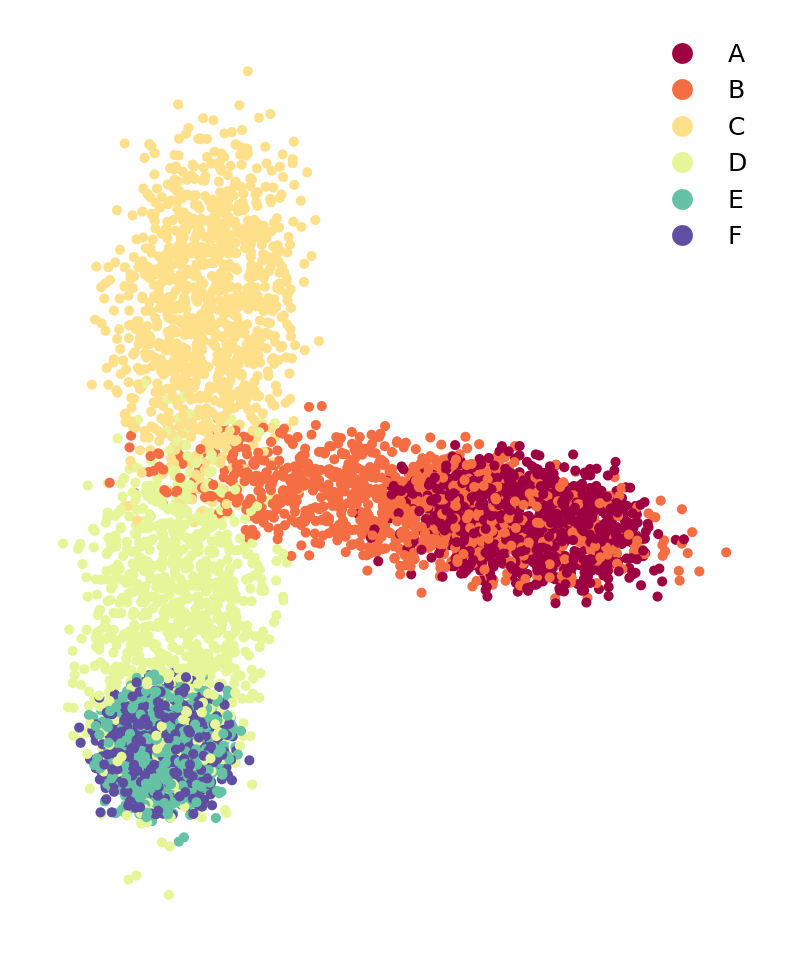

In [6]:
oci.tl.project_2d(x, x_key='view1', projection_key='view1_proj', alpha=60, beta=80)
oci.pl.scatter(x, x_key='view1_proj', color_key='celltype', static=True, marker_size=2)

The third view:

(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot:>)

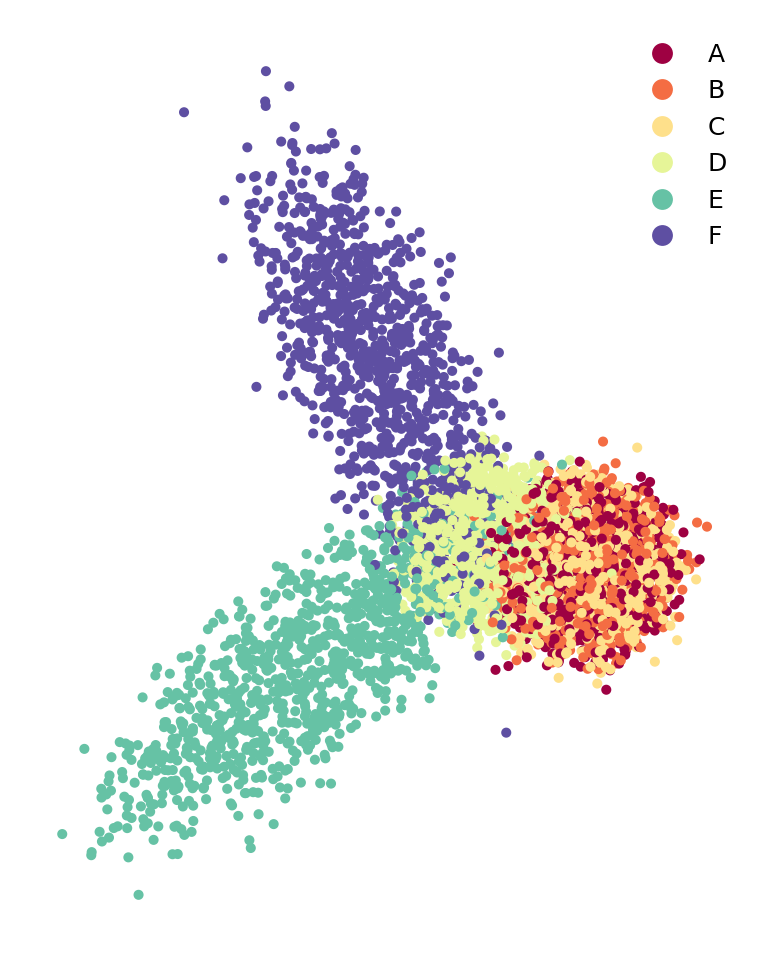

In [7]:
oci.tl.project_2d(x, x_key='view2', projection_key='view2_proj', alpha=30, beta=30)
oci.pl.scatter(x, x_key='view2_proj', color_key='celltype', static=True, marker_size=2)

As seen above, the first view differentiates well between celltypes A-B, the second view between celltypes C-D, and the third view between celltypes E-F. Multi-view diffusion maps' goal is to learn it in unsupervised fashion. 

To begin the analysis, we define which x.obsm keys store views. Ocelli remembers and utilizes this information throughout the whole pipeline.

In [8]:
x.uns['view_keys'] = ['view0', 'view1', 'view2']

Then, we calculate nearest neighbors and multi-view weights. These weights quantify how do views promote the developmental process for each cell.

In [9]:
oci.pp.neighbors(x, n_neighbors=20, mode='sklearn')
oci.tl.weights(x)
x

20 nearest neighbors calculated.
Multi-view weights estimated.


AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'view_keys', 'neighbors', 'distances', 'epsilons'
    obsm: 'view0', 'view1', 'view2', 'view0_proj', 'view1_proj', 'view2_proj', 'weights'

Weights are saved in x.obsm as a pandas.DataFrame of shape (6000, 3). Ocelli provides a tool for visualizing weights distributions.

In [10]:
x.obsm['weights']

,view0,view1,view2
0,0.936710,0.062563,0.000727
1,0.974879,0.023439,0.001682
2,0.982853,0.015938,0.001209
3,0.922858,0.075780,0.001362
4,0.984908,0.013762,0.001329
...,...,...,...
5995,0.000110,0.000145,0.999745
5996,0.000122,0.000148,0.999729
5997,0.000122,0.000148,0.999730
5998,0.000179,0.000137,0.999684


(<Figure size 1800x1200 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'A'}, ylabel='view0'>,
         <AxesSubplot:title={'center':'B'}>,
         <AxesSubplot:title={'center':'C'}>,
         <AxesSubplot:title={'center':'D'}>,
         <AxesSubplot:title={'center':'E'}>,
         <AxesSubplot:title={'center':'F'}>],
        [<AxesSubplot:ylabel='view1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='view2'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

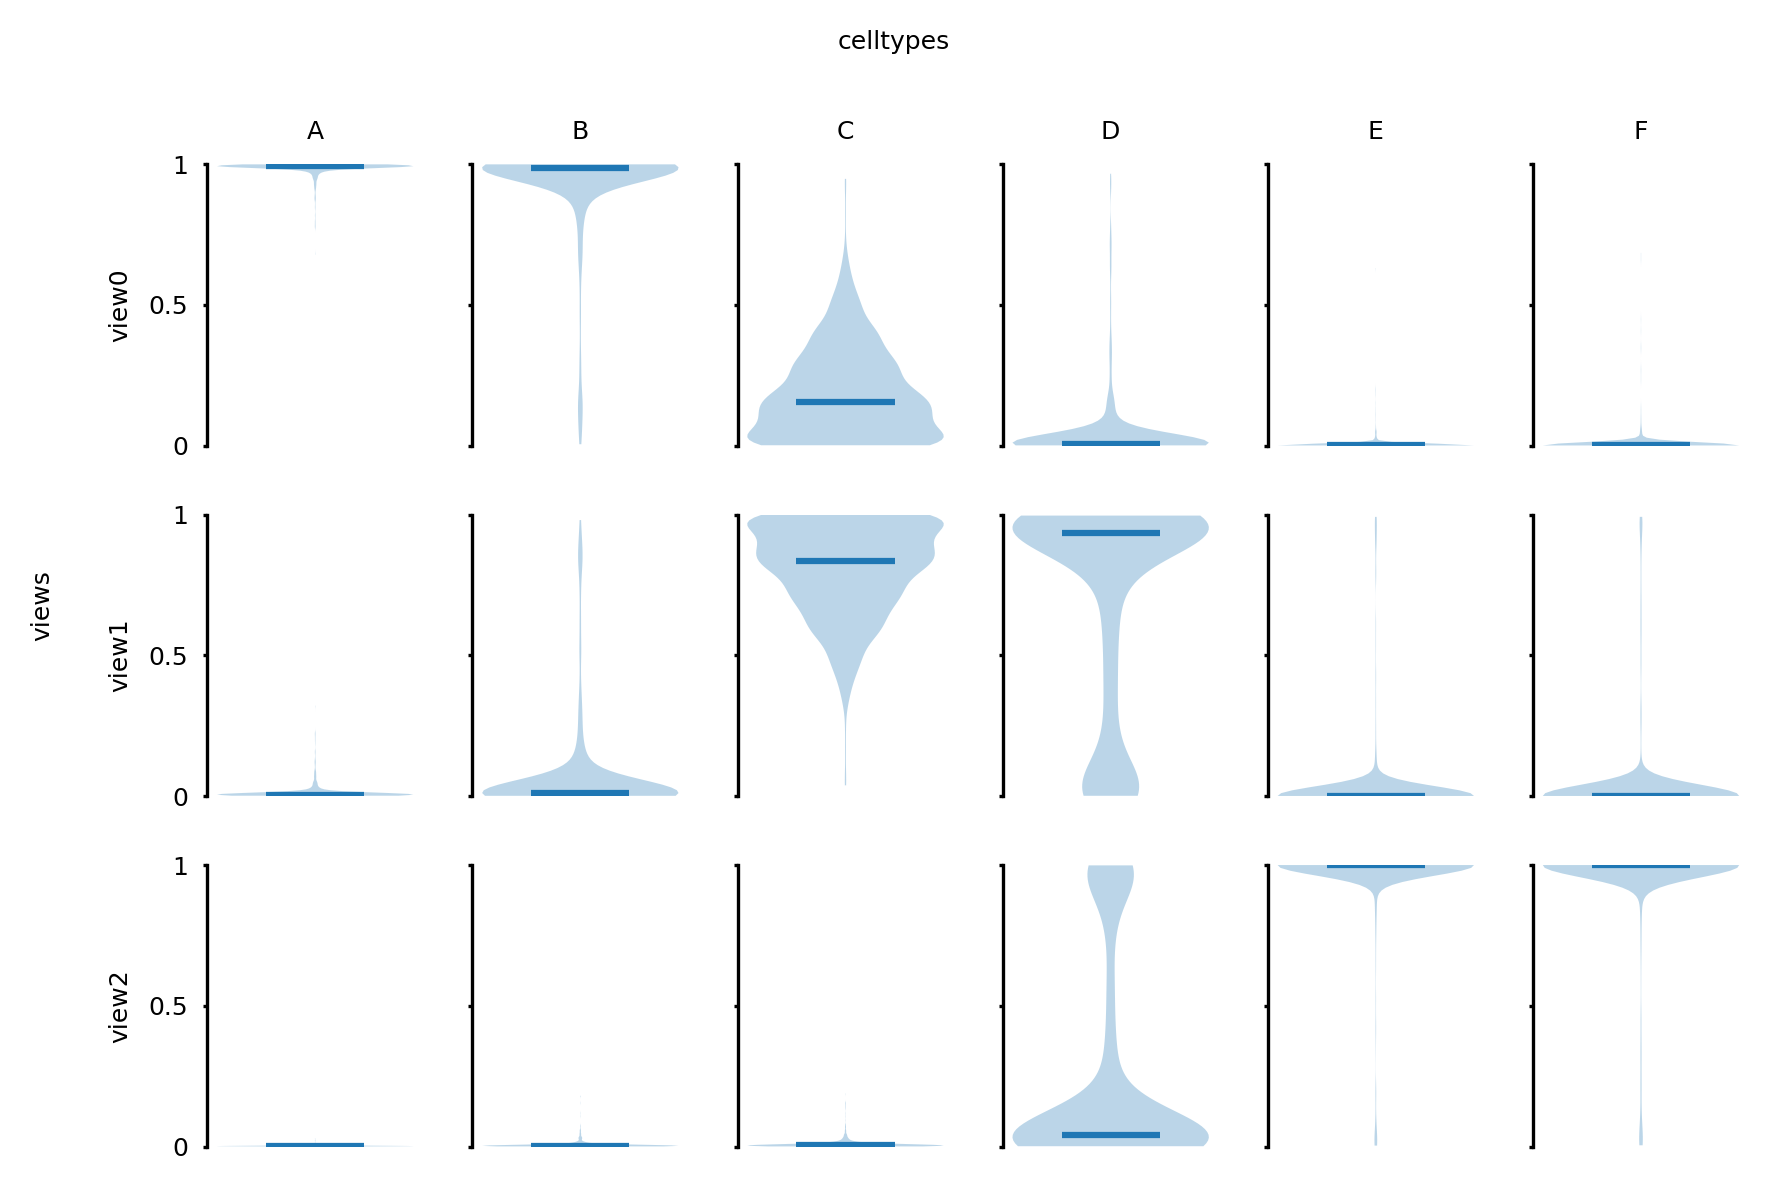

In [11]:
oci.pl.weights(x)

As seen above, MVDM correctly detects which views differentiate which cells. The multi-view weights are then used to calculate the multi-view diffusion maps embedding. In this case, it is 10-dimensional.

In [12]:
oci.tl.multi_view_diffusion_maps(x, n_comps=10, normalize_single_views=False)
x

10 multi-view diffusion maps components calculated.


AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'view_keys', 'neighbors', 'distances', 'epsilons'
    obsm: 'view0', 'view1', 'view2', 'view0_proj', 'view1_proj', 'view2_proj', 'weights', 'x_mvdm'

Now, the nearest neighbors graph is constructed by performing the nearest neighbors search in the multi-view diffusion maps space.

In [13]:
oci.pp.neighbors(x, n_neighbors=30, neighbors_key='neighbors_mvdm', view_keys=['x_mvdm'])
oci.tl.nn_graph(x, n=30, neighbors_key='neighbors_mvdm')
x

30 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'view_keys', 'neighbors', 'distances', 'epsilons', 'neighbors_mvdm'
    obsm: 'view0', 'view1', 'view2', 'view0_proj', 'view1_proj', 'view2_proj', 'weights', 'x_mvdm', 'graph'

Graph is visualized using the [ForceAtlas2](https://github.com/klarman-cell-observatory/forceatlas2) algorithm.

In [14]:
oci.tl.forceatlas2(x, n_steps=5000, is2d=True)
x

Apr 24, 2022 12:32:40 AM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Apr 24, 2022 12:32:41 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 6,000 (6,000 added)
Apr 24, 2022 12:32:41 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 180,000 (108,581 added)


*************************25%
***********

**************50%
*************************75%
*************************100%
Time = 77.298s


AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'view_keys', 'neighbors', 'distances', 'epsilons', 'neighbors_mvdm'
    obsm: 'view0', 'view1', 'view2', 'view0_proj', 'view1_proj', 'view2_proj', 'weights', 'x_mvdm', 'graph', 'x_fa2'

The 2-dimensional embedding is saved to x.obsm[x_fa2].

Plots can be static (showed here) or interactive. 
They can be colored using any metadata from x.obs. 
For static plots, color schemes can be changed by passing the name of any [built-in matplotlib colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html), or a custom colormap object.

Cell types:

(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot:>)

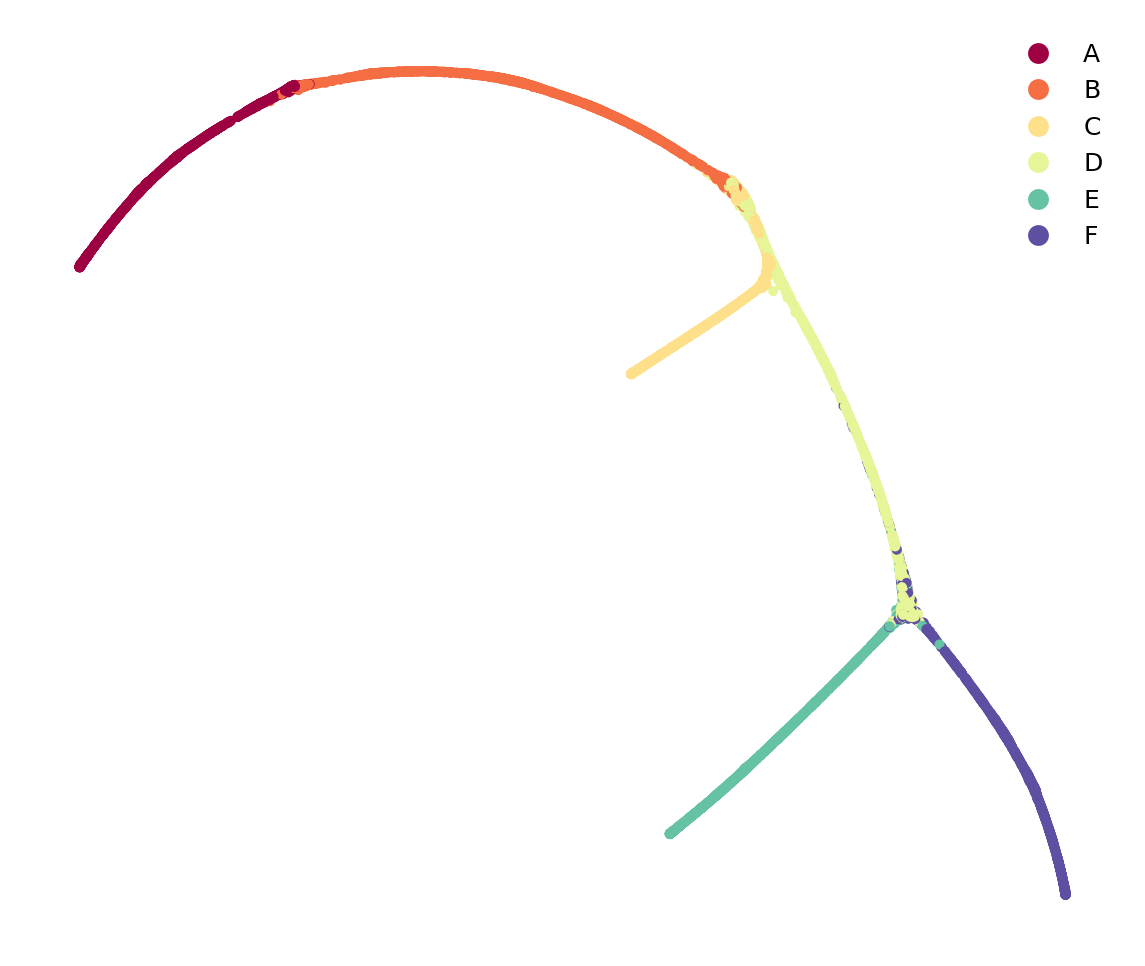

In [15]:
oci.pl.scatter(x, x_key='x_fa2', color_key='celltype', static=True, marker_size=2)

Cell development pseudotime:

(<Figure size 1800x1200 with 2 Axes>, <AxesSubplot:>)

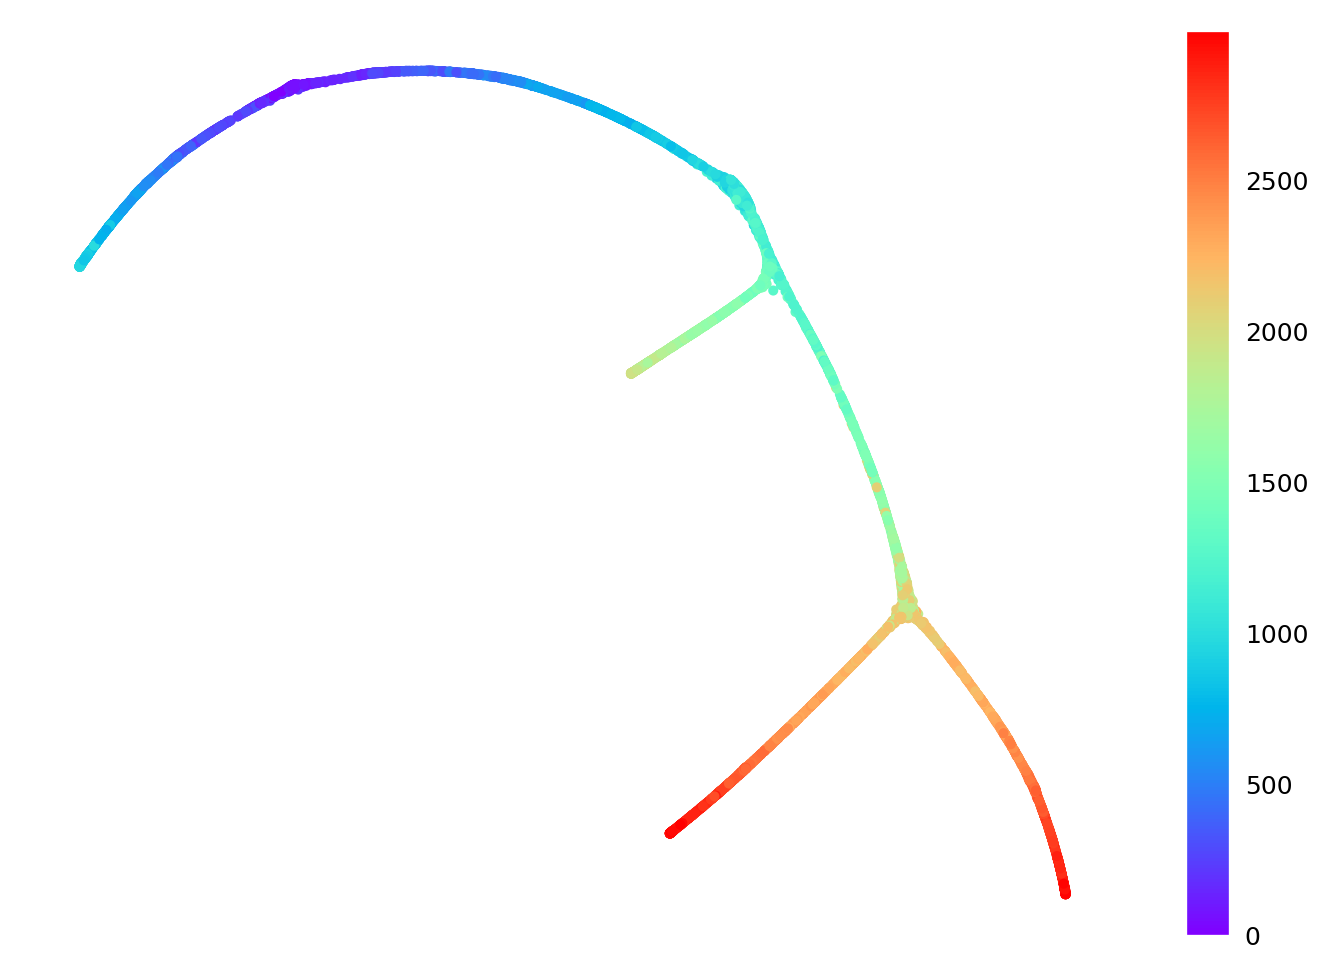

In [16]:
oci.pl.scatter(x, x_key='x_fa2', color_key='pseudotime', static=True, marker_size=2, cmap='rainbow')

The first view's weights:

(<Figure size 1800x1200 with 2 Axes>, <AxesSubplot:>)

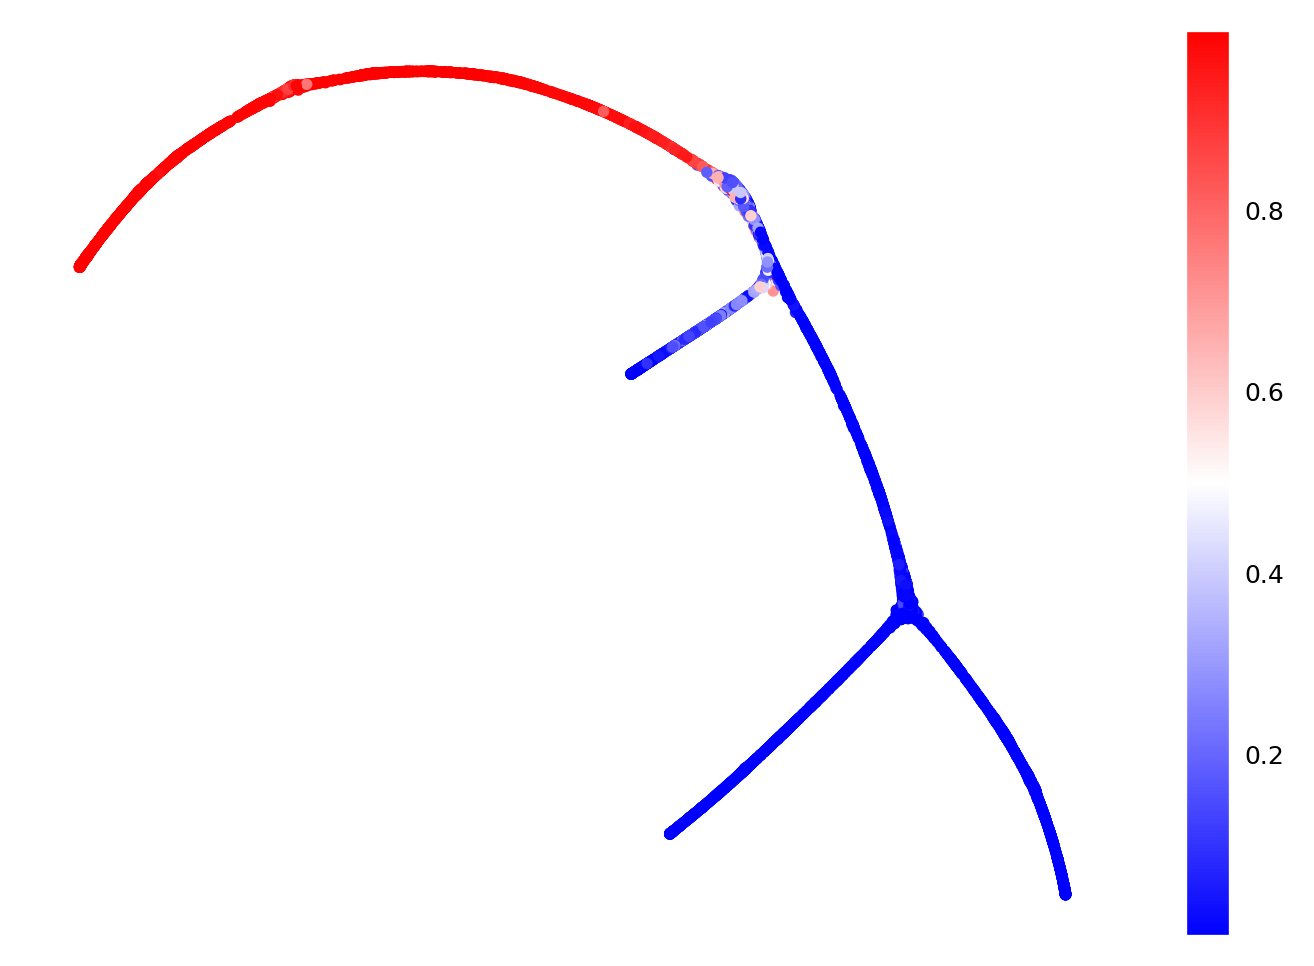

In [17]:
x.obs['weights_view0'] = list(x.obsm['weights']['view0'])
oci.pl.scatter(x, x_key='x_fa2', static=True, color_key='weights_view0', cmap='bwr')

The second view's weights:

(<Figure size 1800x1200 with 2 Axes>, <AxesSubplot:>)

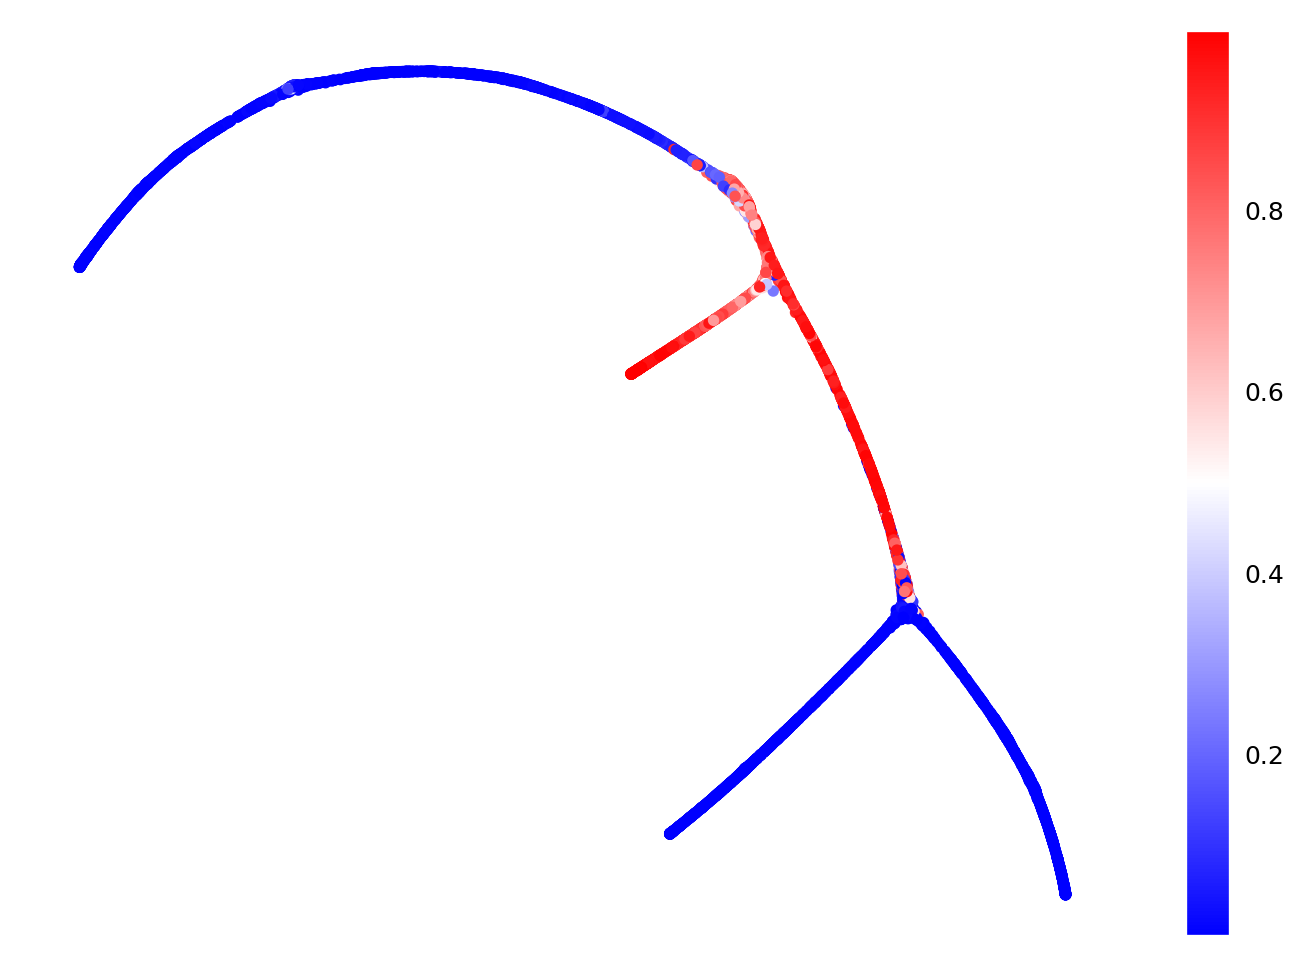

In [18]:
x.obs['weights_view1'] = list(x.obsm['weights']['view1'])
oci.pl.scatter(x, x_key='x_fa2', static=True, color_key='weights_view1', cmap='bwr')

The third view's weights:

(<Figure size 1800x1200 with 2 Axes>, <AxesSubplot:>)

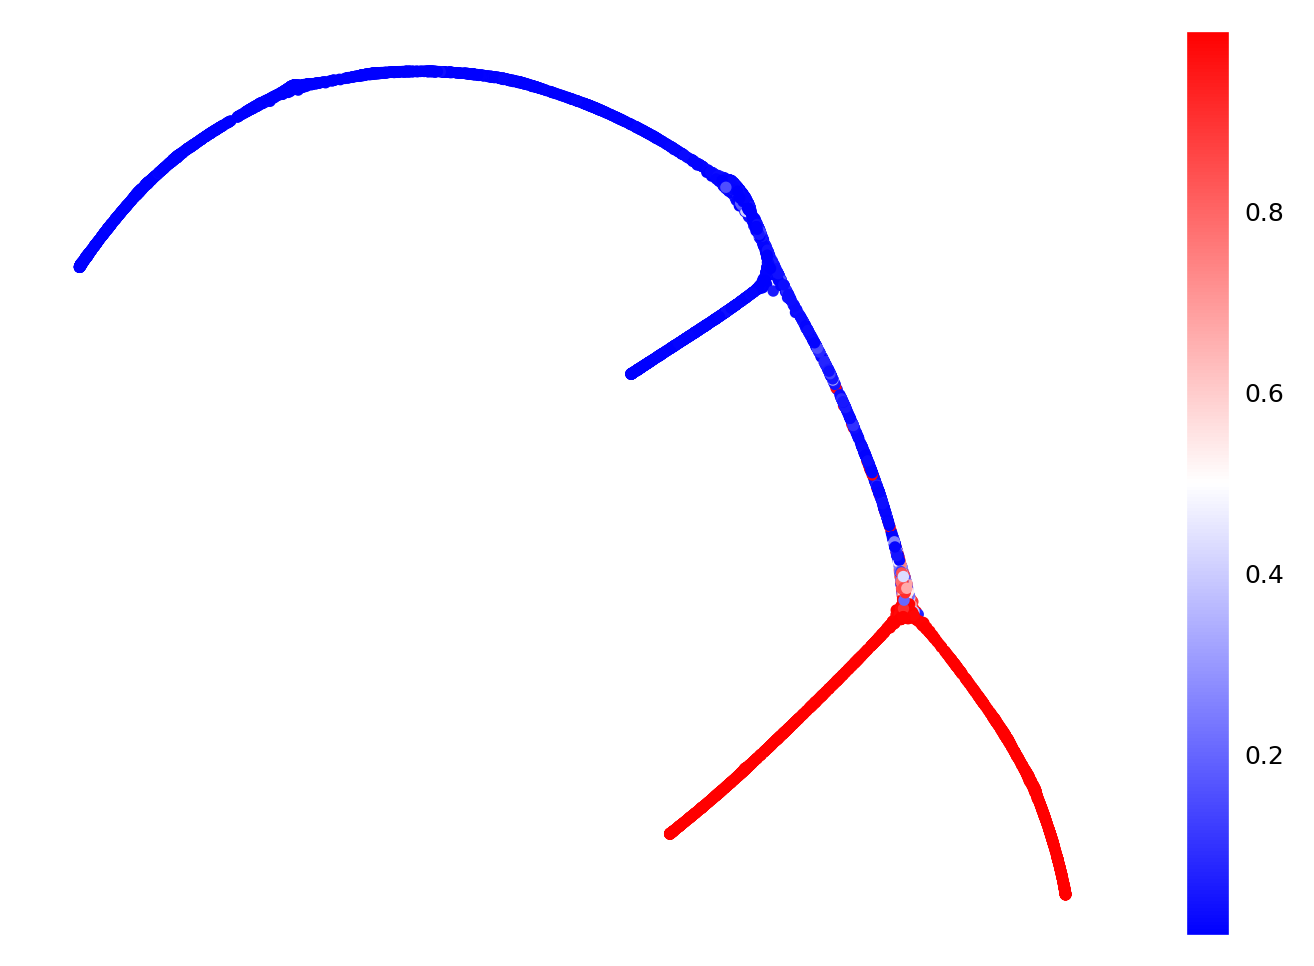

In [19]:
x.obs['weights_view2'] = list(x.obsm['weights']['view2'])
oci.pl.scatter(x, x_key='x_fa2', static=True, color_key='weights_view2', cmap='bwr')